In [1]:
import os
import json
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
#The Goal: 
# A supervised learning algorithm, such as a decision tree or support vector machine, 
# could be used to classify the genre of music based on the data provided. 
# The algorithm would be trained on a dataset of labeled music genres and the associated data values, 
# and then it could be used to predict the genre of music given a new set of data values.

cid ='d8762235995b4ddcbc0df90739df9a63' # Client ID; copy this from your app created on beta.developer.spotify.com
secret = '887a4eccdbde4195bfc0f7f4c472fe70' # Client Secret; copy this from your app
username = '12155311349' # Your Spotify username

#for avaliable scopes see https://developer.spotify.com/web-api/using-scopes/
scope = 'user-library-read playlist-modify-public playlist-read-private'

redirect_uri='https://localhost:8080/callback/'

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 

sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

token = util.prompt_for_user_token(username,scope,client_id=cid,client_secret=secret,redirect_uri="https://localhost:8080/callback/")

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)


In [3]:
#Creating function and having user give PlaylistID, and genre (0 = counrty, 1 = rock...)
def input_playlist(playlistID, genre): 

    playlist = sp.user_playlist(username, playlistID);

    tracks = playlist["tracks"];
    songs = tracks["items"];
    total_tracks = tracks["total"]
    
#     # Iterate over all tracks in the playlist using offset to get beyond the first 100 tracks
    for i in range(100, total_tracks, 100):
        tracks = sp.user_playlist_tracks(username, playlistID, offset=i)
        songs += tracks["items"]
        
    #Putting Track ID, Track Name, Album, and artist name in matrix's

    track_ids = [] 
    track_names = []
    album = []
    artist =[]

    #Getting Track Data
    for i in range(0, len(songs)):
        if songs[i]['track']['id'] != None: # Removes the local tracks in your playlist if there is any
            track_ids.append(songs[i]['track']['id'])
            track_names.append(songs[i]['track']['name'])
            album.append(songs[i]['track']['album']['name'])
            artist.append(songs[i]['track']['artists'][0]['name'])

    features = []
    for i in range(0,len(songs)):
        audio_features = sp.audio_features(track_ids[i])
        for track in audio_features:

          if track is None:
            print(track)
            features.append({'danceability': 0, 'energy': 0, 'key': 0, 'loudness': 0, 'mode': 0, 'speechiness': 0, 'acousticness': 0, 'instrumentalness': 0, 'liveness': 0, 'valence': 0, 'tempo': 0, 'type': 'audio_features', 'id': '00000', 'uri': 'spotify:track:0', 'track_href': 'https://api.spotify.com/', 'analysis_url': 'https://api.spotify.com/', 'duration_ms': 0, 'time_signature': 0})
          else:
            features.append(track)

    #Creating our DataFrames
    df = pd.DataFrame(features, index = track_names) 

    #Adding a new column
    df['genre'] = genre #Country
    df['Song Title'] = track_names
    df['Artist'] = artist

    # Scale between 0 and 1
    df["key"] = (df["key"] / df["key"].max())
    df["tempo"] = (df["tempo"] / df["tempo"].max())
    df["loudness"] = (df["loudness"] / df["loudness"].min())
    
#     #calculate the IQR for instrumentalness and acousticness
    Q1 = df["instrumentalness"].quantile(0.25)
    Q3 = df["instrumentalness"].quantile(0.75)
    IQR = Q3 - Q1
    
    Q12 = df["acousticness"].quantile(0.25)
    Q32 = df["acousticness"].quantile(0.75)
    IQR2 = Q32 - Q12
    
#     #Remove rows with outliers
    df = df[~((df["instrumentalness"] < (df["instrumentalness"].quantile(0.25) - 1.5 * IQR)) | (df["instrumentalness"] > (df["instrumentalness"].quantile(0.75) + 1.5 * IQR)))]
    df = df[~((df["acousticness"] < (df["acousticness"].quantile(0.25) - 1.5 * IQR2)) | (df["acousticness"] > (df["acousticness"].quantile(0.75) + 1.5 * IQR2)))]
    
#     Q1 = df.quantile(0.25)
#     Q3 = df.quantile(0.75)
#     IQR = Q3 - Q1
#     df = df[~((df.sub(Q1, axis=1).div(IQR, axis=1)).lt(-1.5) | (df.sub(Q1, axis=1).div(IQR, axis=1)).gt(1.5)).any(axis=1)]
    return df

In [4]:
# #Bringing in our Test Playlists
# rockPlaylistID ='https://open.spotify.com/playlist/37i9dQZF1DWXRqgorJj26U?si=b4fc7abf24d943b7' 
# countryPlaylistID = 'https://open.spotify.com/playlist/37i9dQZF1DWZBCPUIUs2iR?si=8aa077376b294156' 
# rapPlaylistID = 'https://open.spotify.com/playlist/4riovLwMCrY3q0Cd4e0Sqp?si=d21e717925fe49cb'
# rnbPlaylistID ='https://open.spotify.com/playlist/37i9dQZF1DX04mASjTsvf0?si=b73971c2510f4200'
# popPlaylistID = 'https://open.spotify.com/playlist/7iUGicmg9AkkFhkLiYqYpA?si=042aa88085c24876'
# classicalPlaylistID = 'https://open.spotify.com/playlist/27Zm1P410dPfedsdoO9fqm?si=104c7b4c8cd747f0'

# # country = input_playlist(countryPlaylistID, 0)
# # rock = input_playlist(rockPlaylistID, 1)
# # rap = input_playlist(rapPlaylistID, 2)
# # rnb = input_playlist(rnbPlaylistID,3)
# # pop = input_playlist(popPlaylistID,4)
# # classical = input_playlist(classicalPlaylistID,5)


# country = input_playlist(countryPlaylistID, 'country')
# rock = input_playlist(rockPlaylistID, 'rock')
# rap = input_playlist(rapPlaylistID, 'rap')
# rnb = input_playlist(rnbPlaylistID,'rnb')
# pop = input_playlist(popPlaylistID,'pop')
# classical = input_playlist(classicalPlaylistID,'classical')


In [5]:
# #Putting all the data together
# full_data = pd.concat([rock,country,rnb,pop,classical,rap[:1861]], ignore_index = True)

# full_data_random = full_data.sample(frac=1)
# # full_data_random

# # #Just getting the numerical values, so no ID's, Artists, ect...
# num_data_random = full_data_random[['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','genre',]]
# num_data_random

# #Sending our data to a csv to save computing power and time. All the data is always the same. 
# full_data.to_csv('full_data.csv', index = False)
# full_data_random.to_csv('full_data_random.csv', index=False)
# num_data_random.to_csv('num_data_random.csv', index=False)

In [6]:
#Data has already been created and saved. Check how it is done in AI_Random_Forest to see where the data comes from. It's necessary to save time. 
full_data = pd.read_csv('full_data.csv')
full_data_random = pd.read_csv('full_data_random.csv')
num_data_random = pd.read_csv('num_data_random.csv')

In [7]:
#Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import StandardScaler
from sklearn import tree



In [8]:
# Split the data into features (X) and target (y)
X = num_data_random.drop('genre', axis=1)
y = num_data_random['genre']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale the features using StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [9]:
#Fitting and Evaluating the Model 
rf = RandomForestClassifier(n_estimators = 400, max_depth = 150)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=150, n_estimators=400)

In [10]:
# # plot the first decision tree in the random forest
# fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
# tree.plot_tree(rf.estimators_[0],
#                feature_names = X_train.columns,
#                class_names=y_train.unique(),
#                filled = True,
#               max_depth =1);

# # show the plot
# plt.show()

In [11]:
y_pred = rf.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7096774193548387


In [13]:
import pickle
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

In [14]:
param_dist = {'n_estimators': randint(25,500),
              'max_depth': randint(1,230)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000159C0F0FDF0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000159C0EF6E50>})

In [15]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 130, 'n_estimators': 183}


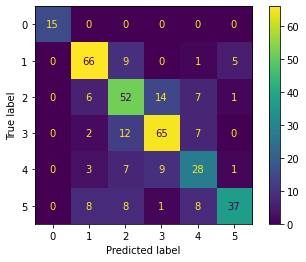

In [16]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [17]:
accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)

Accuracy: 0.706989247311828


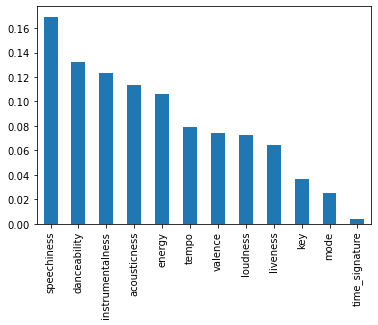

In [18]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [19]:
y_pred

array(['pop', 'pop', 'pop', 'pop', 'pop', 'rnb', 'rap', 'rap', 'rap',
       'country', 'rap', 'country', 'country', 'pop', 'rnb', 'pop',
       'rock', 'rock', 'classical', 'country', 'rnb', 'country',
       'country', 'pop', 'rnb', 'rnb', 'pop', 'rnb', 'pop', 'rap',
       'country', 'rnb', 'country', 'pop', 'classical', 'country', 'pop',
       'rock', 'rock', 'classical', 'pop', 'pop', 'pop', 'rap', 'pop',
       'country', 'rnb', 'pop', 'country', 'rock', 'rnb', 'country',
       'rap', 'rap', 'rap', 'pop', 'rock', 'pop', 'pop', 'pop', 'country',
       'country', 'pop', 'country', 'classical', 'pop', 'rap', 'rock',
       'rap', 'rnb', 'classical', 'rap', 'rnb', 'rap', 'country',
       'country', 'rock', 'rnb', 'country', 'rap', 'pop', 'rnb', 'pop',
       'rnb', 'rap', 'rap', 'rap', 'country', 'pop', 'country', 'rock',
       'rnb', 'rock', 'rock', 'rnb', 'country', 'pop', 'country', 'pop',
       'rap', 'country', 'rap', 'rap', 'pop', 'country', 'rap', 'pop',
       'rap', 'r

In [20]:
#Printing out our y_test
predicted = []
for i in range(0, len(y_test)):
    f=full_data.loc[y_test.index.values[i],:] 
    predicted.append(f)

predicted = pd.DataFrame(predicted) 
predicted[['Artist','Song Title','genre',]]

,Artist,Song Title,genre
2,Billy Idol,White Wedding - Pt. 1,rock
1377,Wolfgang Amadeus Mozart,"Piano Sonata No.16 in C, K.545 ""Sonata facile""...",classical
959,Snoop Dogg,"Young, Wild & Free (feat. Bruno Mars)",pop
783,Khamari,On My Way,rnb
418,Luke Bryan,Country Girl (Shake It For Me),country
...,...,...,...
1701,Kanye West,POWER,rap
1568,Pharoahe Monch,Simon Says,rap
975,Rita Ora,Anywhere,pop
1830,DJ Drama,Free Game,rap


In [21]:
# predicted.to_csv('AI_Results.csv', index=False)
print('Total Songs: ', predicted.index.size)
print('Country: ',  predicted[predicted['genre'] == 'country'].index.size)
print('Rock: ',  predicted[predicted['genre'] == 'rock'].index.size)
print('Rap: ',  predicted[predicted['genre'] == 'rap'].index.size)
print('RnB: ',  predicted[predicted['genre'] == 'rnb'].index.size)
print('Pop: ',  predicted[predicted['genre'] == 'pop'].index.size)
print('Classical: ',  predicted[predicted['genre'] == 'classical'].index.size)


Total Songs:  372
Country:  68
Rock:  61
Rap:  71
RnB:  42
Pop:  116
Classical:  14


In [22]:
#List the Country Songs Predicted
country_pred = predicted[predicted['genre'] == 'country']
country_pred[['Artist','Song Title','genre',]]

,Artist,Song Title,genre
418,Luke Bryan,Country Girl (Shake It For Me),country
558,Zac Brown Band,Chicken Fried,country
405,Darius Rucker,Wagon Wheel,country
399,Jason Aldean,You Make It Easy,country
322,Shania Twain,Man! I Feel Like A Woman!,country
...,...,...,...
492,Devin Dawson,All On Me,country
420,Zac Brown Band,Knee Deep (feat. Jimmy Buffett),country
538,Chris Young,Aw Naw,country
440,Luke Bryan,That's My Kind Of Night,country


In [23]:
# BOXPLOTS of other data
def boxPlot(playlist, genre):
    playlist_num = playlist.drop(columns = ['mode','type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'Song Title', 'Artist'])
    fig, ax = plt.subplots(figsize=(14,7))
    sns.boxplot(data = playlist_num)
    plt.xlabel(genre, fontweight="bold")
    plt.ylabel('Value', fontweight="bold")
    return plt


In [24]:
country_boxplot = boxPlot(country,'Country')
rock_boxplot = boxPlot(rock,'Rock')
rap_boxplot = boxPlot(rap,'Rap')
rnb_boxplot = boxPlot(rnb,'R&B')
pop_boxplot = boxPlot(pop,'POP')
classical_boxplot = boxPlot(classical,'Classical')

NameError: name 'country' is not defined

In [ ]:
# Plot linear correlation matrix
def linear_correlation(playlist,genre):
    playlist_num = playlist.drop(columns = ['mode','type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'genre', 'Song Title', 'Artist'])
    fig, ax = plt.subplots(figsize=(14,7))
    sns.heatmap(playlist_num.corr(), annot=True, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
    plt.title(genre +' Linear Correlation Matrix')
    plt.show()

In [ ]:
linear_correlation(country,'Country')
linear_correlation(rock,'Rock')
linear_correlation(rap,'Rap')
linear_correlation(rnb,'R&B')
linear_correlation(pop,'POP')
linear_correlation(classical,'Classical')

In [ ]:
import plotly.graph_objects as go
import plotly.offline as pyo

def radar_plot(playlist,genre,color):
    playlist_num = playlist.drop(columns = ['mode','type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
           'time_signature', 'genre', 'Song Title', 'Artist'])

    categories = playlist_num.columns
    categories = [*categories, categories[0]]

    mean_r = playlist_num.mean()

    mean_r = [*mean_r, mean_r[0]]


    fig = go.Figure(
        data=[
            go.Scatterpolar(r=mean_r, theta=categories, name= genre,fill='toself',fillcolor = color, ),],
        layout=go.Layout(
            title=go.layout.Title(text= genre+' Mean Values Radar Plot'),
            polar={'radialaxis': {'visible': True}},
            showlegend=True,
        )
    )

    pyo.iplot(fig)

In [ ]:
radar_plot(country,'Country','orange')
radar_plot(rock,'Rock','red')
radar_plot(rap,'Rap','lightblue')
radar_plot(rnb,'R&B','purple')
radar_plot(pop,'POP','pink')
radar_plot(classical,'Classical','green')